In [1]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

/home/bily/miniforge3/envs/ask-volk-today-311/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_CUTOFF = 650  # Everything before this is training data

In [3]:
nv = pd.read_csv("../data/intermediate/national_votes.csv")
sv = pd.read_csv("../data/intermediate/swissvotes.csv")
topics = pd.read_csv("../data/processed/summary_topics.csv")

In [4]:
# Swissvotes vote IDs ("anr" column) are multiplied by 10 for some reason
sv["anr"] /= 10

# Select the relevant rows from swissvotes 
sv = sv[sv["anr"] >= topics["id"].min()]

In [5]:
# Same for national votes from swissdd.
nv["id"] /= 10
nv = nv[nv["id"] >= topics["id"].min()]

In [6]:
# Join nv and topics
nv.dropna(inplace=True)
nv_and_topics = nv.merge(topics, left_on="id", right_on="id")
nv_and_topics

,Unnamed: 0,name,id,canton_id,canton_name,mun_id,mun_name,geoLevelParentnummer,gebietAusgezaehlt,jaStimmenInProzent,...,506 - Education Expansion,507 - Education Limitation,604 - Traditional Morality: Negative,607 - Multiculturalism: Positive,608 - Multiculturalism: Negative,701 - Labour Groups: Positive,702 - Labour Groups: Negative,703 - Agriculture and Farmers: Positive,704 - Middle Class and Professional Groups,705 - Underprivileged Minority Groups
0,1,Bundesbeschluss über den Beitritt der Schweiz ...,338.0,1,Zürich,1,Aeugst am Albis,101,True,31.534091,...,0.005833,0.000833,0.007222,0.009722,0.014167,0.003611,0.000278,0.000278,0.005833,0.004167
1,2,Bundesbeschluss über den Beitritt der Schweiz ...,338.0,1,Zürich,2,Affoltern am Albis,101,True,27.018752,...,0.005833,0.000833,0.007222,0.009722,0.014167,0.003611,0.000278,0.000278,0.005833,0.004167
2,3,Bundesbeschluss über den Beitritt der Schweiz ...,338.0,1,Zürich,3,Bonstetten,101,True,30.572687,...,0.005833,0.000833,0.007222,0.009722,0.014167,0.003611,0.000278,0.000278,0.005833,0.004167
3,4,Bundesbeschluss über den Beitritt der Schweiz ...,338.0,1,Zürich,4,Hausen am Albis,101,True,28.571429,...,0.005833,0.000833,0.007222,0.009722,0.014167,0.003611,0.000278,0.000278,0.005833,0.004167
4,5,Bundesbeschluss über den Beitritt der Schweiz ...,338.0,1,Zürich,5,Hedingen,101,True,29.127726,...,0.005833,0.000833,0.007222,0.009722,0.014167,0.003611,0.000278,0.000278,0.005833,0.004167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748447,793318,Übernahme der EU-Verordnung über die Europäisc...,657.0,26,Jura,6808,Clos du Doubs,2603,True,62.347188,...,0.008667,0.004667,0.012667,0.009333,0.046000,0.032000,0.008667,0.009333,0.012000,0.024667
748448,793319,Übernahme der EU-Verordnung über die Europäisc...,657.0,26,Jura,6809,Haute-Ajoie,2603,True,72.169811,...,0.008667,0.004667,0.012667,0.009333,0.046000,0.032000,0.008667,0.009333,0.012000,0.024667
748449,793320,Übernahme der EU-Verordnung über die Europäisc...,657.0,26,Jura,6810,La Baroche,2603,True,71.820449,...,0.008667,0.004667,0.012667,0.009333,0.046000,0.032000,0.008667,0.009333,0.012000,0.024667
748450,793321,Übernahme der EU-Verordnung über die Europäisc...,657.0,26,Jura,6811,Damphreux-Lugnez,2603,True,69.291339,...,0.008667,0.004667,0.012667,0.009333,0.046000,0.032000,0.008667,0.009333,0.012000,0.024667


In [7]:
nv_and_topics["votedate"] = pd.DatetimeIndex(nv_and_topics["votedate"])
nv_and_topics["year"] = nv_and_topics["votedate"].dt.year
nv_and_topics["year"] -= nv_and_topics["year"].min()
nv_and_topics["month"] = nv_and_topics["votedate"].dt.month / 12

In [8]:
# Drop the columns we don't need
nv_and_topics.drop(
    columns=[
        "Unnamed: 0",
        "name",
        "canton_name",
        "mun_name",
        "geoLevelParentnummer",
        "gebietAusgezaehlt",
        "jaStimmenAbsolut",
        "neinStimmenAbsolut",
        "stimmbeteiligungInProzent",
        "eingelegteStimmzettel",
        "anzahlStimmberechtigte",
        "gueltigeStimmen",
        "votedate",
    ]
, inplace=True)

In [10]:
nv_and_topics["jaStimmenInProzent"] /= 100
nv_and_topics["mun_id"] = nv_and_topics["mun_id"].astype("category")
nv_and_topics["canton_id"] = nv_and_topics["canton_id"].astype("category")

In [12]:
train = nv_and_topics[nv_and_topics["id"] < TEST_CUTOFF]
test = nv_and_topics[nv_and_topics["id"] >= TEST_CUTOFF]

In [13]:
dtrain = xgb.DMatrix(
    train.drop(columns=["jaStimmenInProzent"]),
    label=train["jaStimmenInProzent"],
    enable_categorical=True,
)
dtest = xgb.DMatrix(
    test.drop(columns=["jaStimmenInProzent"]),
    label=test["jaStimmenInProzent"],
    enable_categorical=True,
)

del nv, topics, nv_and_topics

In [14]:
param = {
    # Group 1
    "max_depth": 9,
    "min_child_weight": 0.8,
    # Group 2
    "subsample": 0.6,
    "colsample_bytree": 1.0,
    # Group 3
    "learning_rate": 0.01,
}

bst = xgb.train(param, dtrain, 1000)

In [17]:
bst.eval(dtest)

'[0]\teval-rmse:0.14740704333763904'

In [18]:
pred = bst.predict(dtest, output_margin=True)
explainer = shap.TreeExplainer(bst)
explanation = explainer(dtest)
shap_values = explanation.values
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

1.3709068e-06

In [19]:
explanation.feature_names = train.drop(columns=["jaStimmenInProzent"]).columns

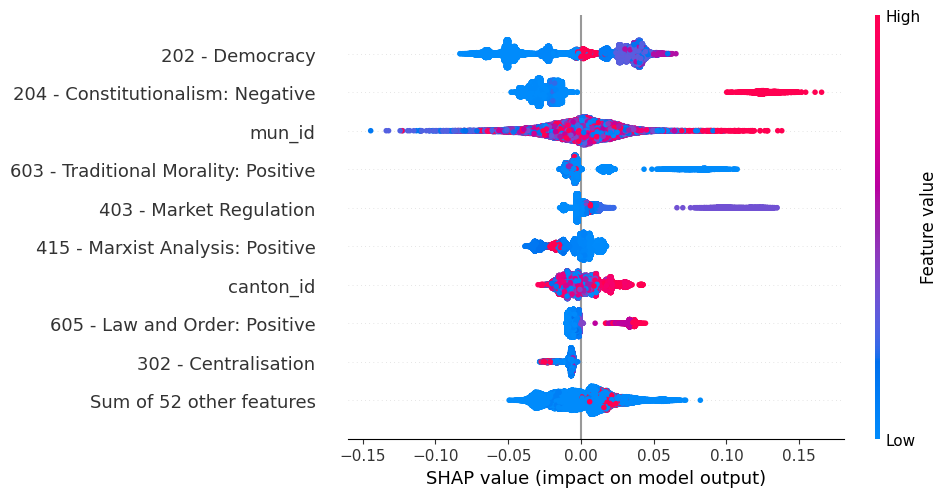

In [20]:
shap.plots.beeswarm(explanation, max_display=10)

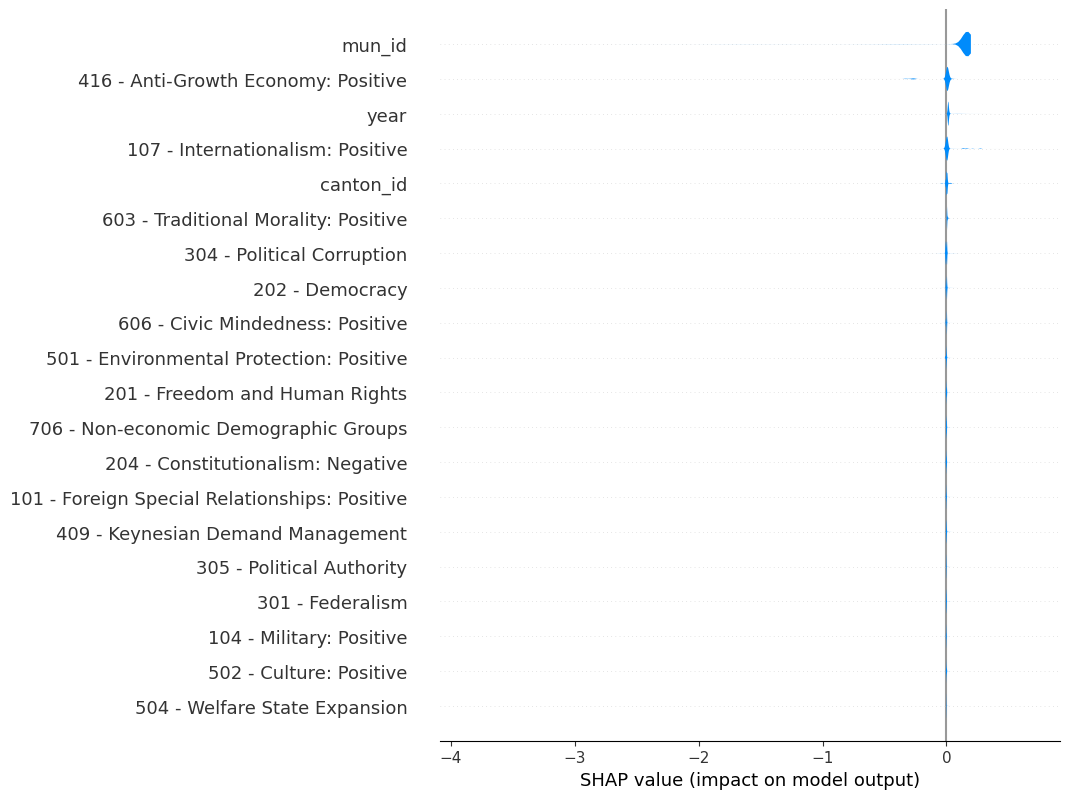

In [ ]:
shap.plots.violin(explanation.values, feature_names=explanation.feature_names)

In [23]:
import pickle
pickle.dump(explanation, open("shap_explanation.pkl", "wb"))